# Preparing a Zarr dataset for our CNN training

**Author:** Eli Holmes (NOAA)

## Goal an xarray Dataset

For fitting our CNN model with TensorFlow, we want an xarray Dataset with our predictors and response variables. We need the variables to be chunked dask arrays. The time dimension should be named `time` and grid `lat` and `lon`, for use in my fitting code. We also need an ocean mask.

## Summary of the steps

* Subset to a smaller spatial region
* Subset to only the variables I need
* Get rid of days with many NaNs

Save in Zarr format. Why Zarr? It is a standard ML-optimized format for gridded data.

* Chunked & lazy loading: Keeps your Dask chunking intact.
* Efficient: Only loads the data you need into memory.
* Parallel IO: Works great with Dask for scalable access.
* Flexible: Plays well with training pipelines in TensorFlow or PyTorch via prefetching or conversion.
  
## Load the libraries that we need

In [15]:
# --- Core data handling libraries ---
import xarray as xr       # for working with labeled multi-dimensional arrays
import numpy as np        # for numerical operations on arrays
import dask.array as da   # for lazy, parallel array operations (used in xarray backends)

# --- Plotting ---
import matplotlib.pyplot as plt  # for creating plots

## Load data

For Part I, we will use a data set in the shared drive. In Part II, we will look at streaming data from the cloud.

In [45]:
# read in the Zarr file; a 3D (time, lat, lon) cube for a bunch of variables in the Indian Ocean
zarr_ds = xr.open_zarr("~/shared/mind_the_chl_gap/IO.zarr")
zarr_ds

<xarray.Dataset> Size: 66GB
Dimensions:                       (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat                           (lat) float32 708B 32.0 31.75 ... -11.75 -12.0
  * lon                           (lon) float32 964B 42.0 42.25 ... 101.8 102.0
  * time                          (time) datetime64[ns] 129kB 1979-01-01 ... ...
Data variables: (12/27)
    CHL                           (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes-cloud                (time, lat, lon) uint8 686MB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes-gapfree              (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes-land                 (lat, lon) uint8 43kB dask.array<chunksize=(177, 241), meta=np.ndarray>
    CHL_cmes-level3               (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes_flags-gapfree        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    ...                            ...
    ug_curr                       (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_curr                        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_wind                        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    vg_curr                       (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_dir                      (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_speed                    (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

## Set up the data for model

For this toy example, we need to pick a response variable (Chlorophyll) without many missing values. We will deal with missing values in our response variable in Part II. The `CHL_cmes-gapfree` variable is the *mostly* gapfree GlobColour CHL product. We will use that. *Mostly* gapfree because the nature of their algorithm means that is some days of the year there will still be NaNs. If a pixel has never been cloud-free on a given day in their training set (like 10-15 years) then that pixel will be NaN. But the `CHL_cmes-gapfree` product is good enough for what we are doing in Part I. We just don't want to use ``CHL_cmes-level3` because that has all the cloud NaNs (i.e. is not gap filled) and has too many NaNs.

### Basic set-up

Slice to a smaller spatial region, pick one year, remove any all NA days.

In [17]:
# predictors
pred_var = ["sst", "so"]
# response variable; this is what we are predicting
resp_var = "CHL_cmes-gapfree"
# our mask for land
land_mask = "CHL_cmes-land"

In [18]:
# slice to a lat/lon segment
data_xr = zarr_ds.sel(lat=slice(35, -5), lon=slice(45,90))

# Get one year of data to work with, so it goes fast
data_xr = data_xr.sortby('time')
data_xr = data_xr.sel(time=slice('2020-01-01', '2020-12-31'))

# Fix a chunk problem
chunk_dict = dict(zip(data_xr["sst"].dims, data_xr["sst"].chunks))
data_xr["so"] = data_xr["so"].chunk(chunk_dict)

### Set up our variables

- Predictor variables: SST (`sst`) and salinity (`so`) and defined above as `pred_var`
- Response variable: gap-filled CHL from GlobColour (`CHL_cmes-gapfree`) which we defined above as `resp_var` and rename to `y`
- A land mask (`CHL_cmes-land`) for the GlobColour data and defined above as `land_mask`

In [19]:
data_xr = data_xr[pred_var + [resp_var, land_mask]]
data_xr = data_xr.rename({resp_var: "y", land_mask: "land_mask"})
data_xr

<xarray.Dataset> Size: 118MB
Dimensions:    (time: 366, lat: 149, lon: 181)
Coordinates:
  * lat        (lat) float32 596B 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon        (lon) float32 724B 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time       (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    sst        (time, lat, lon) float32 39MB dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    so         (time, lat, lon) float32 39MB dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    y          (time, lat, lon) float32 39MB dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    land_mask  (lat, lon) uint8 27kB dask.array<chunksize=(149, 181), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

### Create an ocean mask

We want an ocean mask but we have a land (land=True) mask that includes lakes, which are not ocean.

In [20]:
# Fix the land mask to True/False; ocean = True
data_xr["land_mask"] = data_xr["land_mask"] == 0 
# Mark where SST is always missing (likely lakes)
invalid_ocean = np.isnan(data_xr["sst"]).all(dim="time") 
# Update land_mask: set to False (i.e. land/lake) where SST is always NaN
data_xr["land_mask"] = data_xr["land_mask"].where(~invalid_ocean, other=False)
# Rename our mask to ocean_mask
data_xr = data_xr.rename({"land_mask": "ocean_mask"})

Let's look at our ocean mask. 1 for land and 0 for water/ocean and no big lakes! Great.

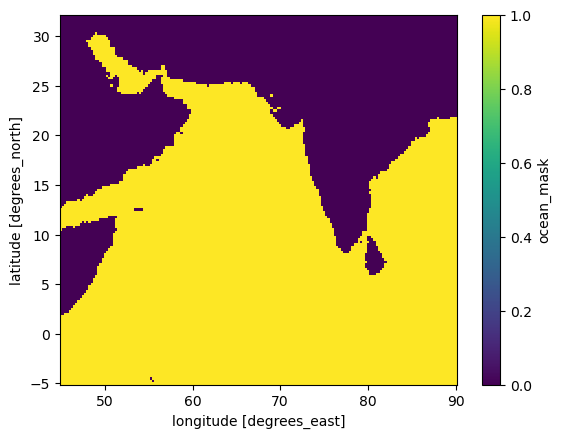

In [21]:
data_xr["ocean_mask"].plot();

## log CHL

In [22]:
data_xr["y"] = np.log(data_xr["y"])

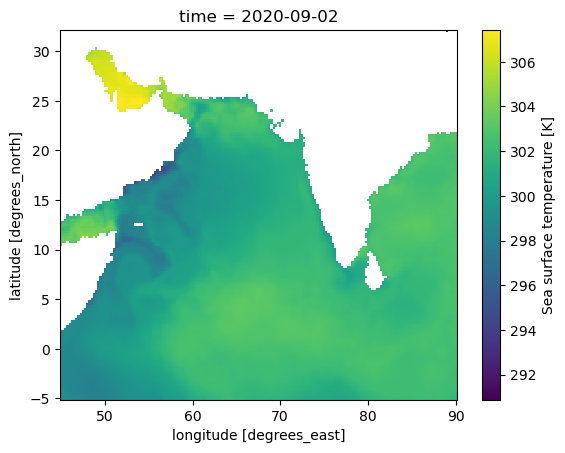

In [23]:
# Let's check
data_xr.sst.sel(time="2020-09-02").plot();

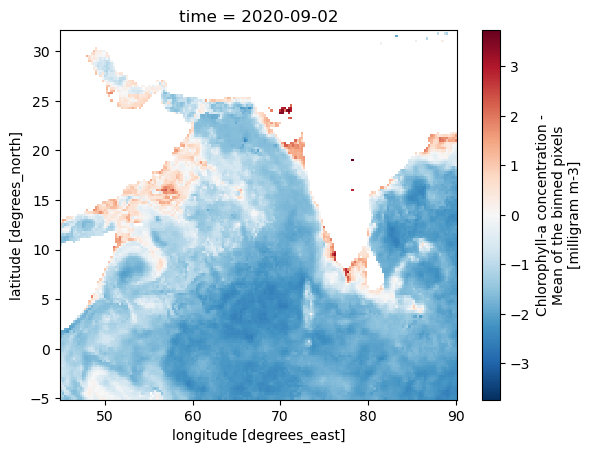

In [24]:
# Hmm some high chl in inland lakes
data_xr.y.sel(time="2020-09-02").plot();

### Deal with NaNs

TensorFlow does not allow NaNs in our predictors so we need to figure out how many there are and then decide what to do about them. It looks like our predictors are fine; SST has zero NaNs or and salinity has a maximum of 79 NaN pixels on any given day. We'll leave those days. But our response variable has some days with a lot of NaNs. We should get rid of those days with high NaNs.

In [25]:
# Check how many NaNs that we have

# Broadcast to 3D: (time, lat, lon) since it is 2D now
mask_3d = data_xr["ocean_mask"].broadcast_like(data_xr["sst"])

# Count NaNs over ocean only
for var in ["sst", "so", "y"]:
    var_data = data_xr[var]
    ocean_nan = np.isnan(var_data) & mask_3d
    max_nan = ocean_nan.sum(dim=["lat", "lon"]).max().compute()
    print(f"{var}: max ocean NaNs per time step = {int(max_nan)}")

sst: max ocean NaNs per time step = 0
so: max ocean NaNs per time step = 79
y: max ocean NaNs per time step = 1602


### Get rid of days where our response has too many NaNs

A rule of thumb is not to have more than 5-10% of NaNs in your response variable, otherwise the CNNs will be training on too much missingness. For us, 5% is about 800 missing pixels.

In [26]:
nan_thresh = 0.05 * data_xr["ocean_mask"].sum().values
nan_thresh

832.0500000000001

In [27]:
# Count missing CHL values over ocean for each time step in CHL
chl_nan = np.isnan(data_xr["y"]) & mask_3d
chl_nan_count = chl_nan.sum(dim=["lat", "lon"])

# Set threshold: exclude days with too much missing CHL
valid_times = chl_nan_count < nan_thresh

# Apply time filtering
data_xr = data_xr.sel(time=valid_times)
print(f"Remaining days after CHL filtering: {data_xr.sizes['time']}")

Remaining days after CHL filtering: 321


### Replace data over land with NaN

Make sure any variables over land are NaN so no lake data.

## Save as a Zarr file

* Chunked & lazy loading: Keeps your Dask chunking intact.
* Efficient: Only loads the data you need into memory.
* Parallel IO: Works great with Dask for scalable access.
* Flexible: Plays well with training pipelines in TensorFlow or PyTorch via prefetching or conversion.

In [39]:
data_xr = data_xr.chunk({'time': 100, 'lat': 50, 'lon': 60})
# clear encoding
for var in data_xr.data_vars:
    data_xr[var].encoding.pop("chunks", None)

In [44]:
type(data_xr)

xarray.core.dataset.Dataset

In [ ]:
data_xr.to_zarr("part1.zarr", mode="w")
# data_xr.to_zarr("~/shared-readwrite/cnn/part1.zarr", mode="w")

In [40]:
# test
test = xr.open_zarr("part1.zarr")
test

<xarray.Dataset> Size: 104MB
Dimensions:     (lat: 149, lon: 181, time: 321)
Coordinates:
  * lat         (lat) float32 596B 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon         (lon) float32 724B 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time        (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    ocean_mask  (lat, lon) bool 27kB dask.array<chunksize=(50, 60), meta=np.ndarray>
    so          (lat, lon, time) float32 35MB dask.array<chunksize=(50, 60, 100), meta=np.ndarray>
    sst         (lat, lon, time) float32 35MB dask.array<chunksize=(50, 60, 100), meta=np.ndarray>
    y           (lat, lon, time) float32 35MB dask.array<chunksize=(50, 60, 100), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

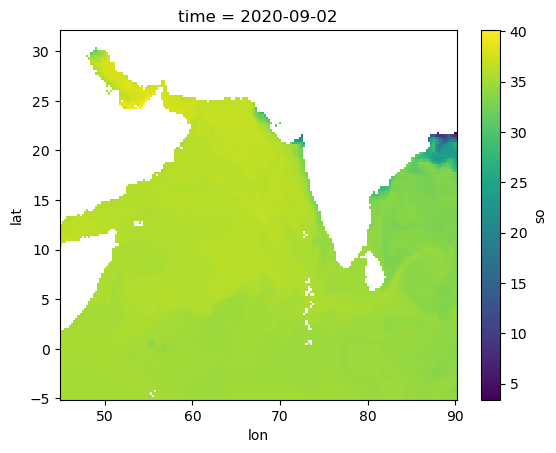

In [41]:
# test plot
test.so.sel(time='2020-09-02').plot()

## Summary

Now we are ready to fit our CNN model.